# Importing , training & saving the pre-trained model

## Install libraries

In [1]:
%pip install transformers
!pip install -q datasets transformers
%pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 182 kB 54.4 MB/s 
     |████████████████████████████████| 7.6 MB 78.4 MB/s 
     |████████████████████████████████| 451 kB 5.0 MB/s 
     |████████████████████████████████| 132 kB 91.5 MB/s 
     |████████████████████████████████| 212 kB 94.9 MB/s 
     |████████████████████████████████| 127 kB 92.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from huggingface_hub import notebook_login
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, DefaultDataCollator , TrainingArguments, Trainer
from google.colab import drive
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from datasets import load_metric, load_dataset
import os

## Load dataset

In [3]:
dataset = load_dataset("fashion_mnist")
dataset

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
dataset["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F632B507D00>,
 'label': 9}

In [5]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [ ]:
dataset["train"][0]['image']

In [ ]:
dataset["train"][0]['image'].resize((200, 200))

In [8]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'Pullover'

## Load metric

In [9]:
metric = load_metric("accuracy")

<ipython-input-9-21f3ecd7ee32>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


## Load feature extractor

In [10]:
extractor = AutoFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
extractor

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

## Preprocessing 

In [11]:
normalize = Normalize(mean=extractor.image_mean, std=extractor.image_std)
_transforms = Compose([RandomResizedCrop((224,224)), ToTensor(), normalize])

In [12]:
def transforms(data):
    data["pixel_values"] = [_transforms(img.convert("RGB")) for img in data["image"]]
    del data["image"]
    return data

In [13]:
dataset = dataset.with_transform(transforms)

In [14]:
dataset['test'][0]

{'label': 9,
 'pixel_values': tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.5765, -0.5765, -0.5765,  ..., -0.0196, -0.0196, -0.0196],
          [-0.5765, -0.5765, -0.5765,  ..., -0.0196, -0.0196, -0.0196],
          [-0.5765, -0.5765, -0.5765,  ..., -0.0196, -0.0196, -0.0196]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.5765, -0.5765, -0.5765,  ..., -0.0196, -0.0196, -0.0196],
          [-0.5765, -0.5765, -0.5765,  ..., -0.0196, -0.0196, -0.0196],
          [-0.5765, -0.5765, -0.5765,  ..., -0.0196, -0.0196, -0.0196]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],

In [15]:
data_collator = DefaultDataCollator()

In [16]:
dataset['test'][0]

{'label': 9,
 'pixel_values': tensor([[[-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922],

## Evaluate

In [17]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

## Training the model

In [18]:
model_checkpoint='microsoft/beit-base-patch16-224-pt22k-ft22k'
batch_size = 32 

In [19]:
model = AutoModelForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224-pt22k-ft22k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True,
)

Downloading:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/414M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args = TrainingArguments(
    output_dir="./results",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=extractor,
    compute_metrics=compute_metrics
)


In [23]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 60000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 4680
  Number of trainable parameters = 85769674


Epoch,Training Loss,Validation Loss,Accuracy
0,0.395200,0.388440,0.858400
1,0.334800,0.362132,0.869100
2,0.263200,0.330321,0.882000
3,0.320100,0.296883,0.894600
4,0.242800,0.294469,0.893300
5,0.200800,0.288883,0.895300
6,0.243900,0.273118,0.902000
7,0.209900,0.260337,0.904700
8,0.200200,0.263076,0.907600
9,0.193000,0.258252,0.908600


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-468
Configuration saved in ./results/checkpoint-468/config.json
Model weights saved in ./results/checkpoint-468/pytorch_model.bin
Image processor saved in ./results/checkpoint-468/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-936
Configuration saved in ./results/checkpoint-936/config.json
Model weights saved in ./results/checkpoint-936/pytorch_model.bin
Image processor saved in ./results/checkpoint-936/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-1404
Configuration saved in ./results/checkpoint-1404/config.json
Model weights saved in ./results/checkpoint-1404/pytorch_model.bin
Image processor saved in ./results/checkpoint-1404/preprocessor_config.json
***** Running Evaluat

***** train metrics *****
  epoch                    =          10.0
  total_flos               = 43307398176GF
  train_loss               =        0.2793
  train_runtime            =    1:42:05.65
  train_samples_per_second =        97.949
  train_steps_per_second   =         0.764


In [24]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =      0.903
  eval_loss               =     0.2606
  eval_runtime            = 0:00:41.51
  eval_samples_per_second =    240.849
  eval_steps_per_second   =      7.539


## Save the trained model

In [51]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
cd /content/drive/MyDrive/Colab Notebooks/Model

/content/drive/MyDrive/Colab Notebooks/Model


In [27]:
trainer.save_model("model0.json")

Saving model checkpoint to model0.json
Configuration saved in model0.json/config.json
Model weights saved in model0.json/pytorch_model.bin
Image processor saved in model0.json/preprocessor_config.json


### Saving Model for Inference

In [28]:
torch.save(model.state_dict(), "./model0_state.pt")

### Loading Model for Inference

In [ ]:
model0_state = AutoModelForImageClassification.from_pretrained("abhishek/autotrain_fashion_mnist_vit_base")
model0_state.load_state_dict(torch.load("./modelo_state.pt"))
model0_state.eval()

###Save Entire Model

In [29]:
torch.save(model, "./model0_full.pt")

### Load Entire Model

In [ ]:
model0_full = torch.load("./model0_full.pt")
model0_full.eval()

## Predict

In [59]:
dataset1 = load_dataset("fashion_mnist")
image = dataset1["train"][1]['image']
encoding = extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1, 3, 224, 224])


In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inputs = encoding.to(device)

In [61]:
device

device(type='cuda', index=0)

In [62]:
with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits

In [63]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: T - shirt / top


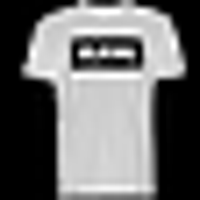

In [41]:
dataset1["train"][1]['image'].resize((200, 200))

## Push model to huggingface

In [47]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [48]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [64]:
trainer.push_to_hub()

Saving model checkpoint to ./results
Configuration saved in ./results/config.json
Model weights saved in ./results/pytorch_model.bin
Image processor saved in ./results/preprocessor_config.json


# Use trained model

## install libraries

In [ ]:
%pip install transformers

## import the trained model

In [104]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
import torch
from datasets import  load_dataset

In [80]:
repo_name = "thilinadj/image_classification_tdj_fashion-mnist"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
created_model = AutoModelForImageClassification.from_pretrained(repo_name)

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--thilinadj--image_classification_tdj_fashion-mnist/snapshots/b794b2cf2fbdd95729aacb70ab6628be6b98c218/preprocessor_config.json
Image processor BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--thilinadj--image_classification_tdj_fashion-mnist/snapshots/b794b2cf2fbdd95729aacb70ab6628be6b98c218/config.json
Model config BeitConfig {
  "_name_or_path": "thilinadj/image_classification_tdj_fashion-mnist",
  "architectures": [
    "BeitForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auxiliary_channels": 256,
  "auxiliary_concat_input": false,
  "auxiliary_loss_weight": 0.4,
  "auxiliary_num_convs": 1,
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "T - shirt / top",
    "1": "Trouser",
    "2": "Pullover",
    "3": "Dress",
    "4": "Coat",
    "5": "Sandal",
    "6": "Shirt",
    "7": "Sneaker",
    "8": "Bag",
    "9": "Ankle boot"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Ankle boot": 9,
    "Bag": 8,
    "Coat": 4,
    "Dress":

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--thilinadj--image_classification_tdj_fashion-mnist/snapshots/b794b2cf2fbdd95729aacb70ab6628be6b98c218/pytorch_model.bin
All model checkpoint weights were used when initializing BeitForImageClassification.

All the weights of BeitForImageClassification were initialized from the model checkpoint at thilinadj/image_classification_tdj_fashion-mnist.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BeitForImageClassification for predictions without further training.


## load the dataset

In [81]:
dataset1 = load_dataset("fashion_mnist")

  0%|          | 0/2 [00:00<?, ?it/s]

## Import image from dataset to predict

In [ ]:
image = dataset1["test"][57]['image']

## Import image from a url to predict

In [105]:
from PIL import Image
import requests

url = 'https://www.charleskeith.com/dw/image/v2/BCWJ_PRD/on/demandware.static/-/Sites-ck-products/default/dwfd4aea2a/images/hi-res/2022-L7-CK2-80781987-19-3.jpg?sw=1152&sh=1536'

image = Image.open(requests.get(url, stream=True).raw)

## View image

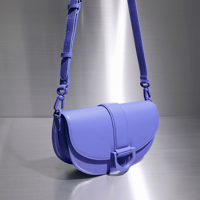

In [107]:
image.resize((200, 200))

## Transform the image

In [106]:
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


## Predict

In [108]:
with torch.no_grad():
  outputs = created_model(**encoding)
  logits = outputs.logits

In [109]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", created_model.config.id2label[predicted_class_idx])

Predicted class: Bag
